In [1]:
%run ../tools/tools/get_SERCA_equilibrium.ipynb

In [2]:
import numpy as np
from scipy.integrate import *
import matplotlib.pyplot as plt
from math import *
from scipy.optimize import *

In [3]:
cai = 100.0e-9
cae = 250e-6

N_avo=6.0221409e23

# Volume Normalisations
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
ntot = 1
ctot = ntot/vol_tot
fvol_cyt = vol_cyt/vol_tot
fvol_er = vol_er/vol_tot

In [4]:
# Reaction Rates
k_orig={
    'kx1_x1a' : 2*1.0e8,
    'kx1a_x2' : 1.0e8,
    'kx1a_x1' : 83.666,
    'kx2_x1a' : 2*83.666,
    'kx2_y2'  : 0.6,
    'ky2_x2'  : 4.118, #corrected
    'ky2_y1a' : 2*30.015,
    'ky1a_y1' : 30.015,
    'ky1a_y2' : 1.0e5,
    'ky1_y1a' : 2*1.0e5,
    'ky1_x1'  : 0.4,
    'kx1_y1'  : 1.20e-3,
    'kleak'     : 0,

    'cbHon'   : 0.55e7,
    'cbHoff'  : 2.6,
    'cbMon'   : 4.35e7,
    'cbMoff'  : 35.8,
     
    'kPMCA01' : 1.5e8,
    'kPMCA10' : 20,
    'kPMCA12' : 100,
    'kPMCA20' : 1e5,
    'kPMCA0leak': 12.5

}

In [59]:
# ODE model
class new_model:
    # Volume Normalisations
    vol_er = (3.9*0.1*0.1)
    vol_cyt = (4.0*0.5*0.5-vol_er)
    vol_tot = vol_cyt + vol_er
    ntot = 1
    ctot = ntot/vol_tot
    fvol_cyt = vol_cyt/vol_tot
    fvol_er = vol_er/vol_tot
    N=0.00026033316269814734
    
    def __init__(self,parameters):
        self.__dict__.update(parameters)
    def ode(self,v,t):
        Ca, PMCA0, PMCA1, PMCA2,\
        cbH0M0, cbH0M1, cbH0M2, cbH1M0, cbH1M1, cbH1M2, cbH2M0, cbH2M1, cbH2M2,\
        fx1, fx1a, fx2, fy2, fy1a, fy1, cae = v 

        dx1 = fx1*(-self.kx1_x1a*cai-self.kx1_y1)+fx1a*self.kx1a_x1+fy1*self.ky1_x1
        dx1a = fx1a*(-self.kx1a_x2*cai-self.kx1a_x1)+fx1*cai*self.kx1_x1a+fx2*self.kx2_x1a
        dx2 = fx2*(-self.kx2_y2-self.kx2_x1a)+fx1a*cai*self.kx1a_x2+fy2*self.ky2_x2

        dy1 = fy1*(-self.ky1_y1a*cae-self.ky1_x1)+fy1a*self.ky1a_y1+fx1*self.kx1_y1
        dy1a = fy1a*(-self.ky1a_y2*cae-self.ky1a_y1)+fy1*cae*self.ky1_y1a+fy2*self.ky2_y1a
        dy2 = fy2*(-self.ky2_x2-self.ky2_y1a)+fy1a*cae*self.ky1a_y2+fx2*self.kx2_y2

        dcae = self.N*(-cae*(fy1a*self.ky1a_y2 + fy1*self.ky1_y1a) + (fy1a*self.ky1a_y1 + fy2*self.ky2_y1a))
        dCa = (Ca*(-fx1*self.kx1_x1a-fx1a*self.kx1a_x2)+fx2*self.kx2_x1a+fx1a*self.kx1a_x1)

        #er leaks
        dcae += self.kleak*(Ca - cae)
        dCa += -self.vol_er/self.vol_cyt*self.kleak*(Ca - cae)

        #print("d(cae)/dt=",dcae*1e6)
        #dcae=0
        
        ### PMCA
        dCa   +=  (self.kPMCA0leak - self.kPMCA01*Ca)*PMCA0 + self.kPMCA10*PMCA1
        dPMCA0 = + self.kPMCA20*PMCA2 + self.kPMCA10*PMCA1 - self.kPMCA01*Ca*PMCA0
        dPMCA1 = - (self.kPMCA12 + self.kPMCA10)*PMCA1 + self.kPMCA01*Ca*PMCA0
        dPMCA2 = - self.kPMCA20*PMCA2 + self.kPMCA12*PMCA1

        ### Calcium Buffers
        dCa   +=     self.cbMoff*(cbH2M1 + cbH1M1 + cbH0M1 + 2*(cbH2M2 + cbH1M2 + cbH0M2)) \
                + self.cbHoff*(cbH2M1 + cbH1M1 + cbH0M1 + 2*(cbH2M2 + cbH2M1 + cbH2M0)) \
             - (+ self.cbMon*(cbH2M1 + cbH1M1 + cbH0M1  + 2*(cbH2M0 + cbH1M0 + cbH0M0)) \
                + self.cbHon*(cbH2M1 + cbH1M1 + cbH0M1  + 2*(cbH0M2 + cbH0M1 + cbH0M0)) )*Ca

        dcbH0M0 = - 2*(self.cbMon+self.cbHon)*cbH0M0*Ca + self.cbMoff*cbH0M1 + self.cbHoff*cbH1M0

        dcbH0M1 = + (2*self.cbMon*cbH0M0 - (self.cbMon + 2*self.cbHon)*cbH0M1)*Ca \
                  + self.cbMoff*(2*cbH0M2 - cbH0M1) + self.cbHoff*cbH1M1

        dcbH0M2 = + self.cbMon*cbH0M1*Ca - 2*(self.cbMoff + self.cbHon*Ca)*cbH0M2 + self.cbHoff*cbH1M2

        dcbH1M0 = + (2*self.cbHon*cbH0M0 - (self.cbHon + 2*self.cbMon)*cbH1M0)*Ca\
                  + self.cbMoff*cbH1M1   + self.cbHoff*(2*cbH2M0 - cbH1M0)

        dcbH1M1 = - ((self.cbMon + self.cbHon)*Ca + (self.cbHoff + self.cbMoff))*cbH1M1\
                  + 2*((self.cbMoff*cbH1M2 + self.cbHoff*cbH2M1) + (self.cbMon*cbH1M0 + self.cbHon*cbH0M1)*Ca)

        dcbH1M2 = + (self.cbMon*cbH1M1 + 2*self.cbHon*cbH0M2 - self.cbHon*cbH1M2)*Ca\
                  - (2*self.cbMoff + self.cbHoff)*cbH1M2 + 2*self.cbHoff*cbH2M2

        dcbH2M0 = + self.cbMoff*cbH2M1 + self.cbHon*cbH1M0*Ca - 2*(self.cbHoff + self.cbMon*Ca)*cbH2M0

        dcbH2M1 = + (self.cbHon*cbH1M1 - self.cbMon*cbH2M1 + 2*self.cbMon*cbH2M0)*Ca\
                  + 2*(self.cbMoff*cbH2M2 - self.cbHoff*cbH2M1) - self.cbMoff*cbH2M1

        dcbH2M2 = + (self.cbMon*cbH2M1 + self.cbHon*cbH1M2)*Ca - 2*(self.cbHoff + self.cbMoff)*cbH2M2

        dX = [dCa, dPMCA0, dPMCA1, dPMCA2,\
              dcbH0M0, dcbH0M1, dcbH0M2, dcbH1M0, dcbH1M1, dcbH1M2, dcbH2M0, dcbH2M1, dcbH2M2,\
              dx1, dx1a, dx2, dy2, dy1a, dy1, dcae]

        return dX

In [79]:
#constructing v0 initial vector
Ca=100e-9
cae=250e-6
pmca = np.array([2.39e-6, 5.82e-7, 4.54e-10])
npmca = 180
p = 180*pmca/sum(pmca)/N_avo/vol_cyt*1e15*1e6# uM
calbindin = [1.48e-05, 7.00e-06, 8.27e-07, 1.21e-05, 5.74e-06, 6.79e-07,\
2.49e-06, 1.18e-06, 1.39e-07] # Total conc. = 45e-6 uM
v0 = [Ca]+list(p)+calbindin+get_SERCA_equilibrium(cae*1e6)+[cae]

#Changing parameters
k=k_orig.copy()
sf=2
sm=270
for key in ['kx1_x1a','kx1a_x2']:
    k[key]=sf*k[key]
for key in ['kx2_y2','ky2_x2','kx1_y1','ky1_x1']:
    k[key]=sm*k[key]

k['kleak']=0.21405838101231592#0.09519188799639043
#print(k)

tstep = 1e-4
tf = 1
t = np.linspace(0, tf, tf/tstep+1)
M=new_model(k)
# Solve ODE
sol = odeint(M.ode,v0,t)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


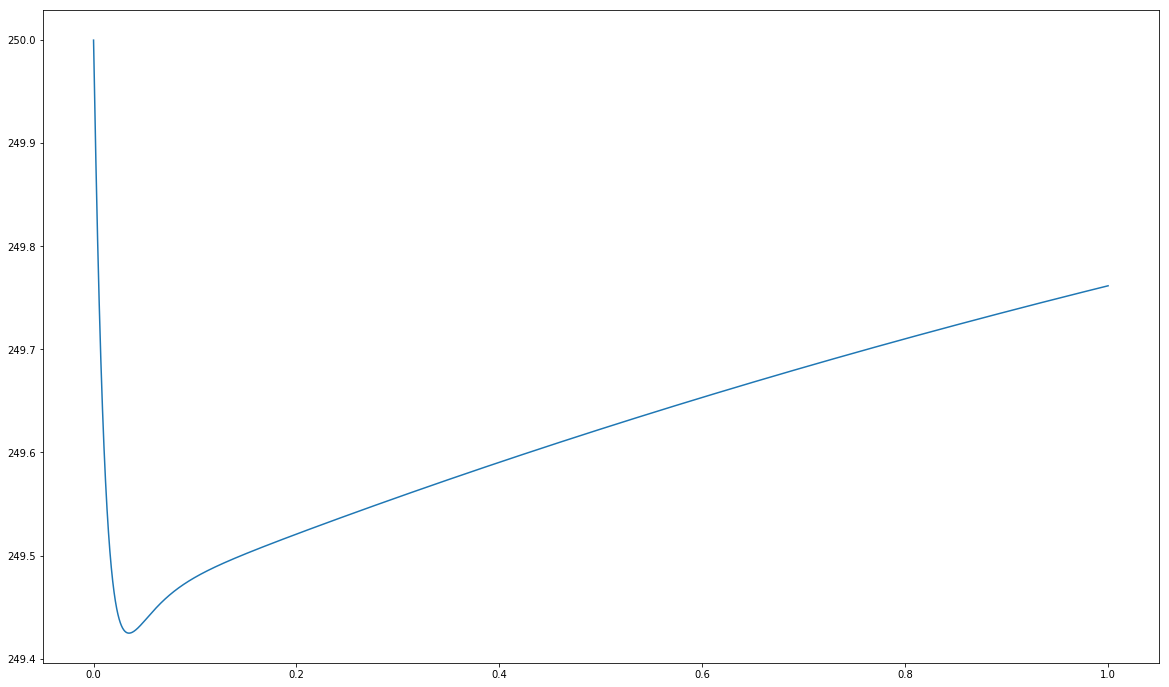

In [80]:
plt.figure(figsize=(20,12))
plt.plot(t,sol[:,-1]*1e6)
#plt.ylim((249.99e-6,250.03e-6))

In [70]:
kleak=577
ER_conc_rate=(2.1675*kleak+6.214988)*1e15/N_avo/vol_er*1e6

ER_conc_rate/250

0.21405838101231592

In [38]:
old=81775.83556434109
serca_conc_rate=500*1e15/N_avo/vol_er*1e6 #from MCell
print("N=",serca_conc_rate/old)

N= 0.00026033316269814734
